In [60]:
!pip3 -q install sklearn pandas seaborn
!pip3 -q install 'keras==2.0.6' --force-reinstall

import pandas as pd
import sklearn
import keras
print("keras version {} installed".format(keras.__version__))
print("pandas version {} installed".format(pd.__version__))
print("scikit-learn version {} installed".format(sklearn.__version__))

keras version 2.0.6 installed
pandas version 0.19.2 installed
scikit-learn version 0.18.1 installed


In [61]:
# %load model_definition.py
"""Create Keras model"""

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm

def create_model(input_dim, output_dim):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(100, input_dim=input_dim, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # hidden layer
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # output layer
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [62]:
# Import pandas 
import train_util as util

helper = util.LendingClubModelHelper()

# Read in lending club data 
helper.read_csv("lc-2015-loans.csv", 
                util.APPLICANT_NUMERIC +
                util.APPLICANT_CATEGORICAL +
                util.CREDIT_NUMERIC +
                util.LABEL)


print(helper.lcdata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 50 columns):
loan_amnt                     421095 non-null int64
term                          421095 non-null object
installment                   421095 non-null float64
grade                         421095 non-null object
emp_length                    421095 non-null object
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
addr_state                    421095 non-null object
dti                           421095 non-null float64
delinq_2yrs                   421095 non-null int64
fico_range_low                421095 non-null int64
fico_range_high               421095 non-null int64
open_acc                      421095 non-null int64
pub_rec                       421095 non-null int64
revol_bal                     421095 non-null int64
revol_util                    421095 non-null float64
total_acc                     421095 non-nul

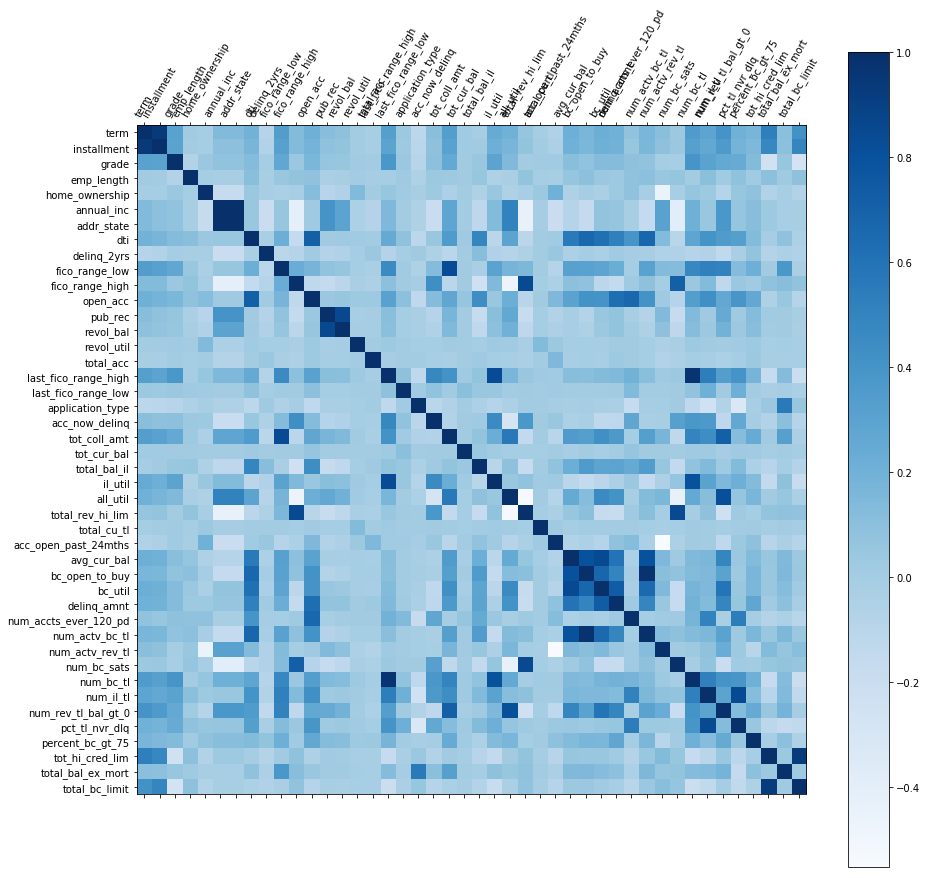

In [66]:
%matplotlib inline

import plot_util as plots

# Show a correlation matrix of the features in our data set
plots.plot_correlation_matrix(helper.lcdata)

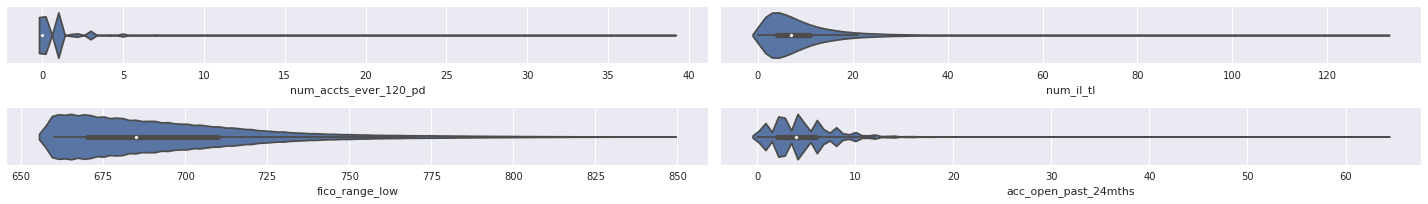

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams["figure.figsize"] = (20,3)

# Create violinplot
plt.subplot(221)
sns.violinplot(x = "num_accts_ever_120_pd", data=helper.lcdata)

plt.subplot(222)
sns.violinplot(x = "num_il_tl", data=helper.lcdata)

plt.subplot(223)
sns.violinplot(x = "fico_range_low", data=helper.lcdata)

plt.subplot(224)
sns.violinplot(x = "acc_open_past_24mths", data=helper.lcdata)

# Show the plot
plt.tight_layout()
plt.show()

In [68]:
import os

# Divide the data set into training and test sets
helper.split_data(util.APPLICANT_NUMERIC + util.CREDIT_NUMERIC,
                  util.APPLICANT_CATEGORICAL,
                  util.LABEL,
                  test_size = 0.2,
                  row_limit = os.environ.get("sample"))

# Inspect our training data
print(helper.x_train.sample())

# Loan grade has been one-hot encoded
print(helper.y_train.sample())

Using only a sample of 50000 observations
        annual_inc      dti  age_earliest_cr  loan_amnt  installment  \
187151    0.720473 -0.04135         3.034325    1.14641     1.369183   

        acc_now_delinq  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  \
187151       -0.070736             -1.145268    -0.436625        0.225688   

         bc_util     ...      TX  UT  VA  VT  WA  WI  WV  WY   36 months  \
187151 -0.002824     ...       0   0   0   0   0   0   0   0           1   

         60 months  
187151           0  

[1 rows x 113 columns]
        grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
237753        1        0        0        0        0        0        0


In [69]:
from model_definition import create_model

history = helper.train_model(create_model)

Beginning model training with batch size 32 and 38 epochs
Train on 32000 samples, validate on 8000 samples
Epoch 1/38
1s - loss: 1.3635 - acc: 0.4145 - val_loss: 1.1973 - val_acc: 0.4738
Epoch 2/38
1s - loss: 1.1760 - acc: 0.4880 - val_loss: 1.0621 - val_acc: 0.5391
Epoch 3/38
1s - loss: 1.0316 - acc: 0.5483 - val_loss: 0.8949 - val_acc: 0.6192
Epoch 4/38
1s - loss: 0.8886 - acc: 0.6121 - val_loss: 0.7339 - val_acc: 0.6964
Epoch 5/38
1s - loss: 0.7814 - acc: 0.6604 - val_loss: 0.6302 - val_acc: 0.7452
Epoch 6/38
1s - loss: 0.7009 - acc: 0.6936 - val_loss: 0.5950 - val_acc: 0.7585
Epoch 7/38
1s - loss: 0.6327 - acc: 0.7282 - val_loss: 0.4938 - val_acc: 0.8100
Epoch 8/38
1s - loss: 0.5952 - acc: 0.7418 - val_loss: 0.4769 - val_acc: 0.8063
Epoch 9/38
1s - loss: 0.5578 - acc: 0.7590 - val_loss: 0.4654 - val_acc: 0.8140
Epoch 10/38
1s - loss: 0.5378 - acc: 0.7713 - val_loss: 0.4350 - val_acc: 0.8253
Epoch 11/38
1s - loss: 0.5159 - acc: 0.7782 - val_loss: 0.4078 - val_acc: 0.8386
Epoch 12/38

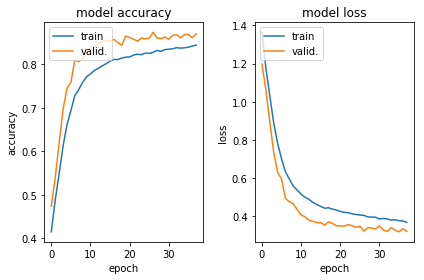

In [77]:
sns.reset_orig()

plots.plot_history(history)

In [78]:
import numpy as np
from sklearn.metrics import f1_score

y_pred = helper.model.predict(helper.x_test.as_matrix())

# Revert one-hot encoding to classes
y_pred_classes = pd.DataFrame((y_pred.argmax(1)[:,None] == np.arange(y_pred.shape[1])),
                              columns=helper.y_test.columns,
                              index=helper.y_test.index)

y_test_vals = helper.y_test.idxmax(1)
y_pred_vals = y_pred_classes.idxmax(1)

# F1 score
# Use idxmax() to convert back from one-hot encoding
f1 = f1_score(y_test_vals, y_pred_vals, average='weighted')
print("Test Set Accuracy: {:.00%}".format(f1))



Test Set Accuracy: 87%


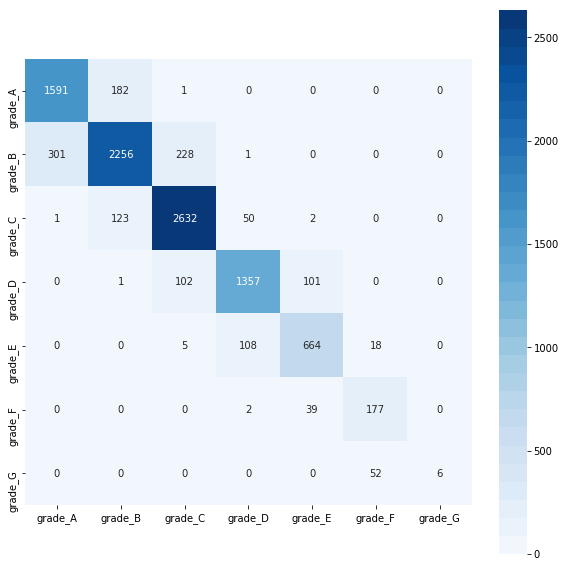

In [79]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cfn_matrix = confusion_matrix(y_test_vals, y_pred_vals)
cfn_frame = pd.DataFrame(cfn_matrix, index=helper.y_test.columns, columns=helper.y_test.columns)

plt.figure(figsize=(10, 10))
sns.heatmap(cfn_frame, square=True, cmap=sns.color_palette("Blues", 30), annot=cfn_matrix, fmt='g')